In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
from glob import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# ================================
# 4.1 Imports and Base Paths
# ================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob
from collections import Counter
from PIL import Image

# For directory-based label handling (same style as your notebooks)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Base directory for Sovit Rath's DR dataset
BASE_DIR = "/kaggle/input/diabetic-retinopathy-224x224-2019-data"
IMG_DIR  = os.path.join(BASE_DIR, "colored_images")

print("Base path:", BASE_DIR)
print("Image path:", IMG_DIR)
print("Available class folders:", os.listdir(IMG_DIR))

Base path: /kaggle/input/diabetic-retinopathy-224x224-2019-data
Image path: /kaggle/input/diabetic-retinopathy-224x224-2019-data/colored_images
Available class folders: ['Mild', 'Proliferate_DR', 'Moderate', 'No_DR', 'Severe']


In [3]:
# ================================
# 4.2 Basic Structure and Counts
# ================================
class_dirs = sorted([d for d in os.listdir(IMG_DIR) if os.path.isdir(os.path.join(IMG_DIR, d))])
print("Detected classes:", class_dirs)

image_records = []

for cls in class_dirs:
    cls_path = os.path.join(IMG_DIR, cls)
    pngs = glob(os.path.join(cls_path, "*.png"))
    jpgs = glob(os.path.join(cls_path, "*.jpg"))
    files = pngs + jpgs
    
    for f in files:
        image_records.append((os.path.basename(f), cls, f))

df_images = pd.DataFrame(image_records, columns=["filename", "label", "filepath"])

print("Total images:", len(df_images))
df_images.head()

Detected classes: ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']
Total images: 3662


,filename,label,filepath
0,f481f76a6b75.png,Mild,/kaggle/input/diabetic-retinopathy-224x224-201...
1,abdb365cacbc.png,Mild,/kaggle/input/diabetic-retinopathy-224x224-201...
2,33ffddea8c6e.png,Mild,/kaggle/input/diabetic-retinopathy-224x224-201...
3,059bc89df7f4.png,Mild,/kaggle/input/diabetic-retinopathy-224x224-201...
4,278aa860dffd.png,Mild,/kaggle/input/diabetic-retinopathy-224x224-201...


In [4]:
# ================================
# 4.4 Mapping Folder Names to DR Grades
# (Optional: use this mapping later in models)
# ================================
# Adjust mapping if your folder names differ
label_mapping = {
    "No_DR": 0,
    "Mild": 1,
    "Moderate": 2,
    "Severe": 3,
    "Proliferate_DR": 4
}

df_images["grade"] = df_images["label"].map(label_mapping)
df_images.head()

,filename,label,filepath,grade
0,f481f76a6b75.png,Mild,/kaggle/input/diabetic-retinopathy-224x224-201...,1
1,abdb365cacbc.png,Mild,/kaggle/input/diabetic-retinopathy-224x224-201...,1
2,33ffddea8c6e.png,Mild,/kaggle/input/diabetic-retinopathy-224x224-201...,1
3,059bc89df7f4.png,Mild,/kaggle/input/diabetic-retinopathy-224x224-201...,1
4,278aa860dffd.png,Mild,/kaggle/input/diabetic-retinopathy-224x224-201...,1


In [5]:
# ================================
# 4.5 Check Image Shapes and Verify 224×224
# (Random subset to avoid heavy IO if needed)
# ================================
sample_paths = df_images["filepath"].sample(min(500, len(df_images)), random_state=42).tolist()

shapes = []
for p in sample_paths:
    with Image.open(p) as img:
        shapes.append(img.size)  # (width, height)

shapes_arr = np.array(shapes)
print("Unique shapes found (width, height):", np.unique(shapes_arr, axis=0))
print("Mean width, height:", shapes_arr.mean(axis=0))

Unique shapes found (width, height): [[224 224]]
Mean width, height: [224. 224.]


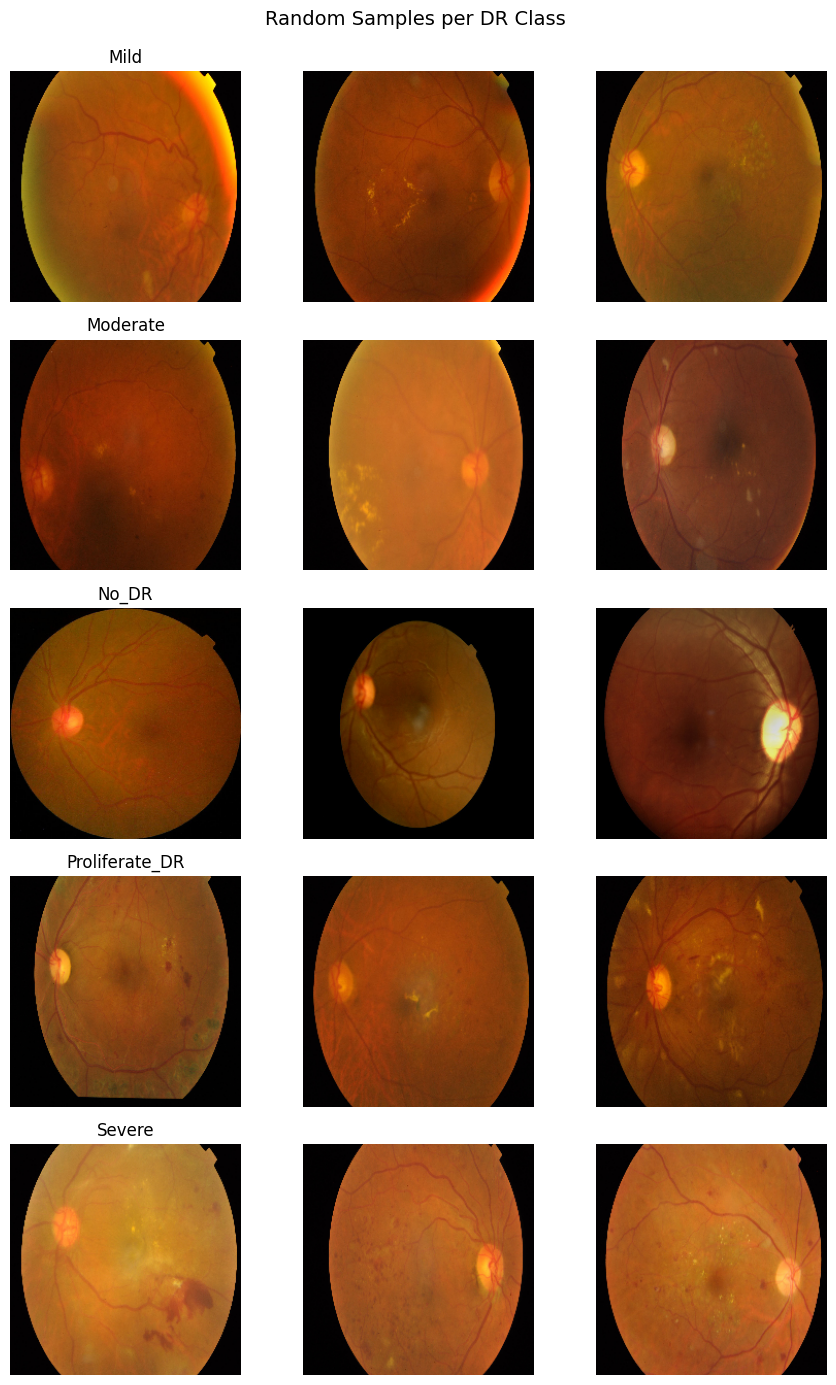

In [6]:
# ================================
# 4.6 Visual Inspection of Sample Images per Class
# ================================
n_classes_to_show = len(class_dirs)
n_per_class = 3  # change to 5 if you want more examples

plt.figure(figsize=(3 * n_per_class, 3 * n_classes_to_show))

for row, cls in enumerate(class_dirs):
    cls_df = df_images[df_images["label"] == cls].sample(min(n_per_class, len(df_images)), random_state=row)
    for col, (_, row_data) in enumerate(cls_df.iterrows()):
        img = Image.open(row_data["filepath"])
        ax = plt.subplot(n_classes_to_show, n_per_class, row * n_per_class + col + 1)
        plt.imshow(img)
        plt.axis("off")
        ax.set_title(cls if col == 0 else "")

plt.suptitle("Random Samples per DR Class \n \n \n \n \n", y=0.92, fontsize=14)
plt.tight_layout()
plt.show()

In [7]:
# ================================
# 4.7 Brightness / Intensity Statistics Per Class
# (Helps understand exposure differences between classes)
# ================================
def compute_brightness(path, resize_to=(64, 64)):
    with Image.open(path) as img:
        img = img.convert("L")  # grayscale
        if resize_to is not None:
            img = img.resize(resize_to)
        arr = np.array(img) / 255.0
        return arr.mean()

brightness_records = []

for cls in class_dirs:
    # sample a fixed number per class to keep it light
    cls_files = df_images[df_images["label"] == cls]["filepath"].sample(
        min(200, df_images[df_images["label"] == cls].shape[0]),
        random_state=42
    )
    for f in cls_files:
        brightness_records.append((cls, compute_brightness(f)))

df_brightness = pd.DataFrame(brightness_records, columns=["label", "brightness"])

print(df_brightness.groupby("label")["brightness"].describe())

                count      mean       std       min       25%       50%  \
label                                                                     
Mild            200.0  0.273320  0.059354  0.137258  0.231391  0.269741   
Moderate        200.0  0.271654  0.060142  0.131772  0.227449  0.270850   
No_DR           200.0  0.255317  0.081027  0.076954  0.181954  0.278436   
Proliferate_DR  200.0  0.258668  0.057946  0.106848  0.226588  0.260434   
Severe          193.0  0.256653  0.067448  0.131222  0.202565  0.251781   

                     75%       max  
label                               
Mild            0.312044  0.471215  
Moderate        0.314462  0.421024  
No_DR           0.326432  0.405252  
Proliferate_DR  0.292738  0.406501  
Severe          0.308454  0.460043  


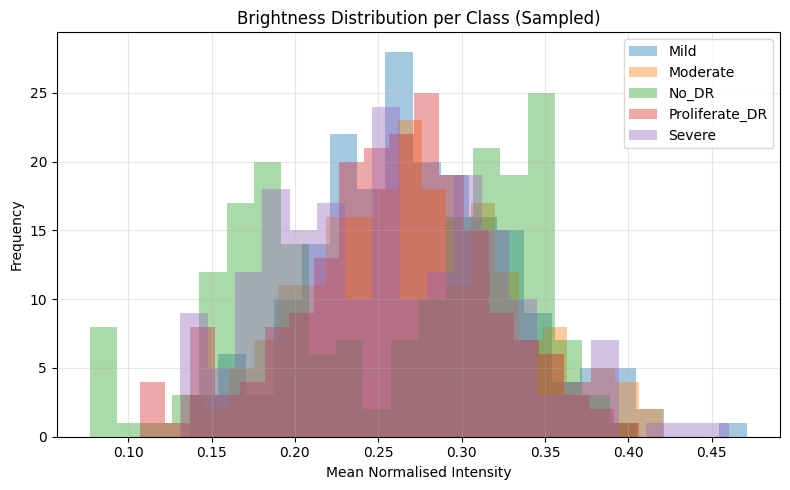

In [8]:
# ================================
# 4.8 Plot Brightness Distribution Per Class
# ================================
plt.figure(figsize=(8, 5))

for cls in class_dirs:
    subset = df_brightness[df_brightness["label"] == cls]["brightness"]
    plt.hist(subset, bins=20, alpha=0.4, label=cls)

plt.title("Brightness Distribution per Class (Sampled)")
plt.xlabel("Mean Normalised Intensity")
plt.ylabel("Frequency")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [9]:
# ================================
# 4.9 Directory-Based EDA via ImageDataGenerator
# (Aligned with your Keras pipelines)
# ================================
datagen = ImageDataGenerator(rescale=1./255)

eda_gen = datagen.flow_from_directory(
    directory=IMG_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

print("Found images:", eda_gen.n)
print("Class indices mapping:", eda_gen.class_indices)

Found 3662 images belonging to 5 classes.
Found images: 3662
Class indices mapping: {'Mild': 0, 'Moderate': 1, 'No_DR': 2, 'Proliferate_DR': 3, 'Severe': 4}


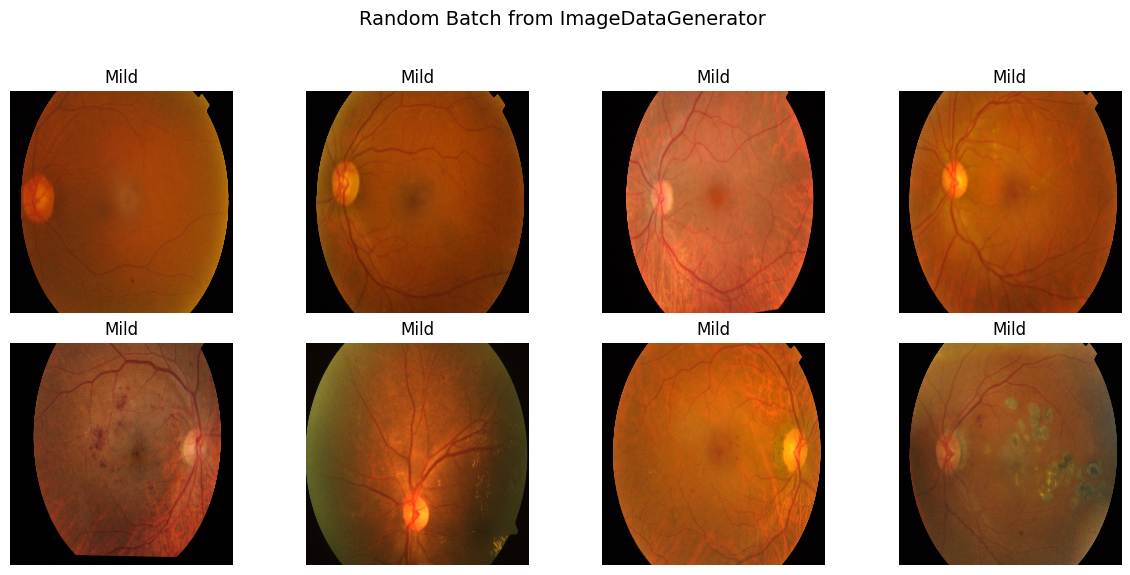

In [10]:
# ================================
# 4.10 Quick Batch Visualisation (As Seen by the Model)
# ================================
batch_x, batch_y = next(eda_gen)

plt.figure(figsize=(12, 6))
for i in range(8):
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(batch_x[i])
    label_idx = np.argmax(batch_y[i])
    # reverse mapping from index to label
    idx_to_class = {v: k for k, v in eda_gen.class_indices.items()}
    ax.set_title(idx_to_class[label_idx])
    plt.axis("off")

plt.suptitle("Random Batch from ImageDataGenerator \n \n", y=0.95, fontsize=14)
plt.tight_layout()
plt.show()

In [11]:
# Path to your image folder
data_dir = "/kaggle/input/diabetic-retinopathy-224x224-2019-data/colored_images/Severe"

# Load all images and resize to 64x64 for DCGAN
image_paths = glob(os.path.join(data_dir, "*.png")) + glob(os.path.join(data_dir, "*.jpg"))

def load_and_preprocess_image(path):
    img = load_img(path, target_size=(64, 64))
    img = img_to_array(img)
    img = (img - 127.5) / 127.5  # Normalize to [-1, 1]
    return img

images = np.array([load_and_preprocess_image(path) for path in image_paths])
print("Dataset shape:", images.shape)

# Create TensorFlow dataset
BUFFER_SIZE = len(images)
BATCH_SIZE = 32

dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


Dataset shape: (193, 64, 64, 3)


In [12]:
def make_generator_model():
    model = tf.keras.Sequential([
        layers.Dense(8*8*256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((8, 8, 256)),

        layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(3, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

generator = make_generator_model()
generator.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (Batch  (None, 16384)             65536     
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 128)       819200    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 16, 16, 128)       5

In [13]:
def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[64, 64, 3]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5,5), strides=(2,2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

discriminator = make_discriminator_model()
discriminator.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        4864      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 128)       0         
                                                                 
 flatten (Flatten)           (None, 32768)            

In [14]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [15]:
EPOCHS = 5000
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)
        print(f"✅ Epoch {epoch+1}/{epochs} completed")


In [16]:
train(dataset, EPOCHS)
print("🎉 Training completed!")


2025-11-24 06:04:59.741594: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-11-24 06:05:03.844586: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


✅ Epoch 1/5000 completed
✅ Epoch 2/5000 completed
✅ Epoch 3/5000 completed
✅ Epoch 4/5000 completed
✅ Epoch 5/5000 completed
✅ Epoch 6/5000 completed
✅ Epoch 7/5000 completed
✅ Epoch 8/5000 completed
✅ Epoch 9/5000 completed
✅ Epoch 10/5000 completed
✅ Epoch 11/5000 completed
✅ Epoch 12/5000 completed
✅ Epoch 13/5000 completed
✅ Epoch 14/5000 completed
✅ Epoch 15/5000 completed
✅ Epoch 16/5000 completed
✅ Epoch 17/5000 completed
✅ Epoch 18/5000 completed
✅ Epoch 19/5000 completed
✅ Epoch 20/5000 completed
✅ Epoch 21/5000 completed
✅ Epoch 22/5000 completed
✅ Epoch 23/5000 completed
✅ Epoch 24/5000 completed
✅ Epoch 25/5000 completed
✅ Epoch 26/5000 completed
✅ Epoch 27/5000 completed
✅ Epoch 28/5000 completed
✅ Epoch 29/5000 completed
✅ Epoch 30/5000 completed
✅ Epoch 31/5000 completed
✅ Epoch 32/5000 completed
✅ Epoch 33/5000 completed
✅ Epoch 34/5000 completed
✅ Epoch 35/5000 completed
✅ Epoch 36/5000 completed
✅ Epoch 37/5000 completed
✅ Epoch 38/5000 completed
✅ Epoch 39/5000 compl

In [17]:
generator.save("/kaggle/working/dcgan_generator3_severe.h5")
discriminator.save("/kaggle/working/dcgan_discriminator3_severe.h5")
print("Models saved successfully!")


Models saved successfully!


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
from glob import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [19]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import os
# Load saved generator model
loaded_generator = load_model("/kaggle/working/dcgan_generator3_severe.h5")

# Create folder to save images
save_dir = "/kaggle/working/dataset3"
os.makedirs(save_dir, exist_ok=True)

# Generate 20 new images
noise = tf.random.normal([20, 100])
generated_images = loaded_generator(noise, training=False)

# Rescale to [0, 255] for saving
generated_images = (generated_images * 127.5 + 127.5).numpy().astype(np.uint8)

for i, img in enumerate(generated_images):
    save_path = os.path.join(save_dir, f"generated_{i+1}.png")
    plt.imsave(save_path, img)
    print(f"Saved: {save_path}")

print("✅ 20 Generated images saved to dataset2 folder.")


Saved: /kaggle/working/dataset3/generated_1.png
Saved: /kaggle/working/dataset3/generated_2.png
Saved: /kaggle/working/dataset3/generated_3.png
Saved: /kaggle/working/dataset3/generated_4.png
Saved: /kaggle/working/dataset3/generated_5.png
Saved: /kaggle/working/dataset3/generated_6.png
Saved: /kaggle/working/dataset3/generated_7.png
Saved: /kaggle/working/dataset3/generated_8.png
Saved: /kaggle/working/dataset3/generated_9.png
Saved: /kaggle/working/dataset3/generated_10.png
Saved: /kaggle/working/dataset3/generated_11.png
Saved: /kaggle/working/dataset3/generated_12.png
Saved: /kaggle/working/dataset3/generated_13.png
Saved: /kaggle/working/dataset3/generated_14.png
Saved: /kaggle/working/dataset3/generated_15.png
Saved: /kaggle/working/dataset3/generated_16.png
Saved: /kaggle/working/dataset3/generated_17.png
Saved: /kaggle/working/dataset3/generated_18.png
Saved: /kaggle/working/dataset3/generated_19.png
Saved: /kaggle/working/dataset3/generated_20.png
✅ 20 Generated images saved t

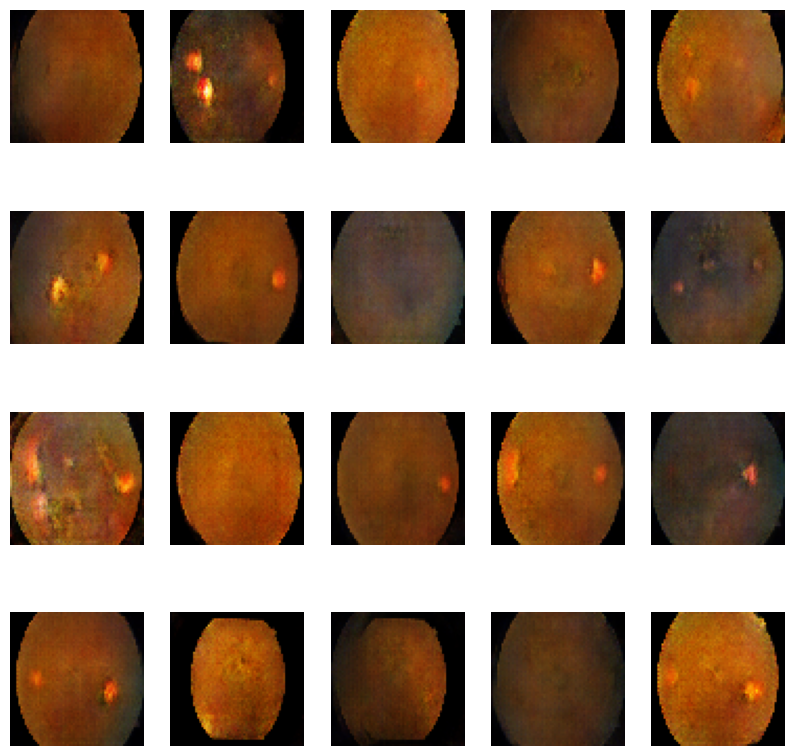

In [20]:
plt.figure(figsize=(10, 10))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(generated_images[i])
    plt.axis('off')
plt.show()
